In [139]:
import geopandas as gpd
from shapely import wkt

In [59]:
gdf=gpd.read_file("activities_geo.json")
gdf.set_index("id", inplace=True)
gdf.geometry[gdf.geometry.notnull()] = gdf[gdf.geometry.notnull()].geometry.apply(lambda x: x.simplify(0.001, preserve_topology=False))
gdf.to_file("activities_geo_compr.json", driver="GeoJSON")
tempdic=gdf[gdf.index=="9058273521"].to_dict(orient="index")["9058273521"]
tempdic["start_date_local"]=str(tempdic["start_date_local"])
tempdic["geometry"]=tempdic["geometry"].wkt

In [91]:
from google.cloud import secretmanager
from stravalib.client import Client
from firebase_admin import db, initialize_app, get_app
from shapely.geometry import LineString
client = secretmanager.SecretManagerServiceClient()
strava_at = client.access_secret_version(request={"name": "projects/stravamap-386413/secrets/strava_access_token/versions/latest"}).payload.data.decode("UTF-8")
sclient = Client(access_token=strava_at)
try:
    default_app = get_app()
except ValueError:
    default_app = initialize_app()
ref = db.reference(url="https://stravamap-386413-default-rtdb.europe-west1.firebasedatabase.app")

In [93]:
test=sclient.protocol.get(f"/activities/{3617831760}",include_all_efforts=True)

1202
LINESTRING (8.69347 47.0283, 8.69346 47.02833, 8.69355 47.02828, 8.69357 47.02832, 8.69362 47.02832, 8.69358 47.02831, 8.69357 47.0283, 8.69355 47.0283, 8.69355 47.02829, 8.69351 47.02832, 8.69349 47.02831, 8.69349 47.02827, 8.69347 47.02828, 8.69347 47.0283, 8.69349 47.0283, 8.6934 47.02838, 8.69339 47.02845, 8.69341 47.02846, 8.69343 47.02843, 8.6934 47.02847, 8.69347 47.02848, 8.69344 47.02851, 8.6935 47.02852, 8.69348 47.02852, 8.69348 47.02848, 8.69342 47.02847, 8.69339 47.02845, 8.69331 47.02845, 8.6933 47.0285, 8.69333 47.02852, 8.69334 47.02856, 8.69322 47.02854, 8.69319 47.02845, 8.69313 47.02843, 8.69273 47.02836, 8.69276 47.02835, 8.69277 47.02836, 8.69275 47.02835, 8.6928 47.02831, 8.69278 47.02829, 8.69273 47.02829, 8.69273 47.02827, 8.6927 47.02825, 8.69248 47.0282, 8.69249 47.02823, 8.69255 47.02824, 8.69259 47.02822, 8.69261 47.02824, 8.69258 47.02831, 8.6925 47.02826, 8.6924 47.02826, 8.69232 47.02829, 8.69215 47.02823, 8.69209 47.02823, 8.69208 47.02824, 8.69231 

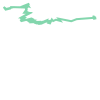

In [117]:
import polyline
print(len(test["map"]["polyline"]))
pl=polyline.decode(test["map"]["summary_polyline"],5,geojson=True)
pll=LineString(pl)
print(pll)
pll=pll.simplify(0.0001, preserve_topology=False)
print(len(pll.coords))
pll

In [49]:
def update_activity(id):
    act_in = sclient.protocol.get(f"/activities/{id}",include_all_efforts=True)
    act = {}
    print(act_in)
    act["name"] = act_in["name"]
    act["distance"] = act_in["distance"]
    act["total_elevation_gain"] = act_in["total_elevation_gain"]
    act["elapsed_time"] = act_in["elapsed_time"]
    act["type"] = act_in["type"]
    act["sport_type"] = act_in["sport_type"]
    act["start_date_local"] = act_in["start_date_local"]
    try:
        ls=LineString([[y,x] for x,y in sclient.get_activity_streams(id, types=["latlng"], resolution='medium')["latlng"].data])
        ls=ls.simplify(.001,preserve_topology=False)
        act["geometry"] = ls.wkt
    except:
        print(f"Problem with activity {id}")
    ref.child(str(id)).update(act)

In [44]:
clouddb = ref.get()
act_ids = clouddb.keys()
i=0
for act_id in act_ids:
    if not "geometry" in clouddb[act_id]:
        i+=1
        print("Updating", act_id)
        update_activity(act_id)
    else:
        print("Skipping", act_id)
    if i>100:
        break

Skipping 209180122
Skipping 209290421
Skipping 210062587
Skipping 210062588
Skipping 211634679
Skipping 211634686
Skipping 212412919
Skipping 212829304
Skipping 213566812
Skipping 213566820
Skipping 214367634
Skipping 215510407
Skipping 215510418
Skipping 215839608
Skipping 216079627
Skipping 218540901
Skipping 218540911
Skipping 218540917
Skipping 218868621
Skipping 219147109
Skipping 219147125
Skipping 219474567
Skipping 220176802
Skipping 220378147
Skipping 220868895
Skipping 220868900
Skipping 221297691
Skipping 221297701
Skipping 222001859
Skipping 223478101
Skipping 223478117
Skipping 224100435
Skipping 224376810
Skipping 226086609
Skipping 226086627
Skipping 226449957
Skipping 227131322
Skipping 227543805
Skipping 228667915
Skipping 228667931
Skipping 229356761
Skipping 229737365
Skipping 229737374
Skipping 230010240
Skipping 230495971
Skipping 230831555
Skipping 231438154
Skipping 232418349
Skipping 233135383
Skipping 233135388
Skipping 233136060
Skipping 233136061
Skipping 233

Fault: 500 Server Error: Internal Server Error [error: None]

In [79]:
acts=sclient.get_activities(after="2023-01-01T00:00:00Z", before="2023-06-01T00:00:00Z", limit=50)

In [109]:
res=sclient.protocol.get("/athlete/activities",page=1)

In [123]:
for i in range(150):
    try:
        activities = sclient.protocol.get("/athlete/activities",page=i)
        print(f"Page {i} downloaded")
    except Exception as e:
        print(f"Problem with page {i} due to {e}")
    for act in activities:
        if "athlete" in act:
            act.pop("athlete")
        if "map" in act:
            try:
                act["geometry"]=LineString(polyline.decode(act["map"]["summary_polyline"],5,geojson=True)).wkt
            except Exception as e:
                print(f"Problem with polyline for {act['id']} due to {e}")
            act.pop("map")
        if "start_latlng" in act:
            act.pop("start_latlng")
        if "end_latlng" in act:
            act.pop("end_latlng")
        id = act.pop("id")
        print(f"{id} updated")
        ref.child(str(id)).update(act)

Page 101 downloaded
407526688 updated
406992880 updated
406003450 updated
404283795 updated
402187953 updated
401572067 updated
400429592 updated
400357864 updated
393661400 updated
393532913 updated
377306114 updated
377306092 updated
377306084 updated
373430908 updated
372795480 updated
370549032 updated
368030423 updated
368030456 updated
368030418 updated
366020037 updated
366104544 updated
366102405 updated
366020071 updated
363473541 updated
363473553 updated
363473533 updated
362441362 updated
359547668 updated
359547607 updated
358009227 updated
Page 102 downloaded
356810001 updated
356022994 updated
352935645 updated
352264428 updated
350849182 updated
349762968 updated
349762847 updated
9036508386 updated
349762856 updated
349762839 updated
349762834 updated
349762825 updated
9078121342 updated
349762841 updated
349762826 updated
344015064 updated
341681502 updated
341681474 updated
Problem with polyline for 341681478 due to IllegalArgumentException: point array must contain 

In [121]:
ref.get()

{'resource_state': 2,
 'name': '07/04/2015 Starnberg, Bayern, Germany',
 'distance': 0.0,
 'moving_time': 0,
 'elapsed_time': 0,
 'total_elevation_gain': 0.0,
 'type': 'Swim',
 'sport_type': 'Swim',
 'id': 341681478,
 'start_date': '2015-07-04T11:59:25Z',
 'start_date_local': '2015-07-04T13:59:25Z',
 'timezone': '(GMT+01:00) Europe/Berlin',
 'utc_offset': 7200.0,
 'location_city': 'Starnberg',
 'location_state': 'Bayern',
 'location_country': 'Germany',
 'achievement_count': 0,
 'kudos_count': 0,
 'comment_count': 0,
 'athlete_count': 1,
 'photo_count': 0,
 'map': {'id': 'a341681478',
  'summary_polyline': 'c|{cHcpedA',
  'resource_state': 2},
 'trainer': False,
 'commute': False,
 'manual': False,
 'private': False,
 'visibility': 'everyone',
 'flagged': False,
 'gear_id': None,
 'start_latlng': [47.989301, 11.338428],
 'end_latlng': [47.989301, 11.338428],
 'average_speed': 0.0,
 'max_speed': 0.0,
 'has_heartrate': False,
 'heartrate_opt_out': False,
 'display_hide_heartrate_option':

In [111]:
ref.child("9089089539").get()

{'achievement_count': 9,
 'athlete_count': 1,
 'average_cadence': 79.1,
 'average_heartrate': 132.9,
 'average_speed': 7.934,
 'average_temp': 12,
 'average_watts': 283.7,
 'comment_count': 0,
 'commute': False,
 'device_watts': True,
 'display_hide_heartrate_option': True,
 'distance': 29538.0,
 'elapsed_time': 3790,
 'elev_high': 851.8,
 'elev_low': 426.0,
 'external_id': 'garmin_ping_274711286729',
 'flagged': False,
 'from_accepted_tag': False,
 'gear_id': 'b2354792',
 'geometry': 'LINESTRING (8.55959 47.36209, 8.5602 47.36189, 8.56055 47.36172, 8.56109 47.3605, 8.56094 47.36038, 8.55984 47.36002, 8.55874 47.35971, 8.55795 47.35955, 8.5579 47.35944, 8.55811 47.35893, 8.55966 47.35711, 8.56111 47.35567, 8.56141 47.35507, 8.56141 47.35449, 8.56158 47.35371, 8.56207 47.35287, 8.5631 47.35168, 8.56411 47.35005, 8.56495 47.34927, 8.56541 47.34865, 8.56707 47.34685, 8.56923 47.34482, 8.5711 47.34289, 8.57133 47.34241, 8.57162 47.34104, 8.5718 47.34086, 8.57263 47.34049, 8.57277 47.34037,

In [73]:
import polyline
len(LineString(polyline.decode("ekzeHqcfbB~EwUdAq]eDyLkBqVPsaAlA{JxLm]fFa_@cJwbA\\igAqAoVeBkHkL_TaCmLtAaHeDmGfFmNlG{HnYqGjJhHbHyAReRvJeMd^uVzZiEzUmIzHyGjAyG~YoWfN_Ip`@ec@`g@cd@rTwIha@cHdXePjLbAtKjFj]`[bZlRt^bKb^aM~VsYxZyBzLsJlDQzCjEzIlYrFrH`@rJpi@`LxFzK`Aj]}@bRxOr@",5,geojson=True)).wkt)

1042

In [131]:
import pandas as pd
df=pd.DataFrame.from_dict(ref.get(), orient="index")

In [143]:
print(df["country"].value_counts())
print(df.start_date_local.min())
#df.loc[df.geometry.notnull(),"geometry"] = df[df.geometry.notnull()].geometry.apply(wkt.loads)
gdf = gpd.GeoDataFrame(df[df.geometry.notnull()], geometry="geometry")
gdf.to_file("activities_geo_test.json", driver="GeoJSON")

Austria               1364
Switzerland           1107
Germany                208
United Kingdom         164
Italy                  135
France                  41
Solomon Islands         34
United States           26
Iceland                 23
Norway                  20
Canada                  10
India                    7
Morocco                  7
Georgia                  6
Chile                    4
Argentina                3
Sweden                   3
New Caledonia            3
Russian Federation       3
Sri Lanka                2
Denmark                  2
Poland                   1
Albania                  1
Spain                    1
Serbia                   1
Name: country, dtype: int64
2014-10-19T12:01:13Z


In [148]:
from shapely import wkt
import pandas as pd
import geopandas as gpd
from firebase_admin import db, initialize_app, get_app
#initialize_app()
get_app()
ref = db.reference(url="https://stravamap-386413-default-rtdb.europe-west1.firebasedatabase.app")
df=pd.DataFrame.from_dict(ref.get(),orient="index")
df.loc[df.geometry.notnull(),"geometry"] = df[df.geometry.notnull()].geometry.apply(wkt.loads)
gdf = gpd.GeoDataFrame(df[df.geometry.notnull()], geometry="geometry")
gdf = gdf[["name","total_elevation_gain","distance","elapsed_time","start_date_local","geometry","type"]]

In [149]:
gdf["geometry"]=gdf.geometry.apply(lambda x: x.simplify(0.001, preserve_topology=False))

In [232]:
ref = db.reference(url="https://stravamap-386413-default-rtdb.europe-west1.firebasedatabase.app")
df=pd.DataFrame.from_dict(ref.get(),orient="index")
df=df[df.geometry.notnull()]
df.loc[df.geometry.notnull(),"geometry"] = df[df.geometry.notnull()].geometry.apply(wkt.loads)
#gdf = gpd.GeoDataFrame(df[df.geometry.notnull()], geometry="geometry")
df["geometry"] = df.geometry.apply(lambda x: x.simplify(0.0001, preserve_topology=False))
df = df[df.geometry.apply(lambda x: len(x.coords)) > 0]
df["polyline"] = df.geometry.apply(lambda x: polyline.encode(x.coords,5,geojson=True))
df = df[["name","total_elevation_gain","distance","elapsed_time","start_date_local","polyline","type"]]
#gdf.to_file("public/strava.geojson", driver="GeoJSON")
#gdf["polyline"] = gdf.geometry.apply(lambda x: polyline.encode(x.coords,5,geojson=True))
#df=pd.DataFrame.from_dict(gdf.to_dict(orient="index"),orient="index")
#df.drop(columns=["geometry"],inplace=True)
df.to_json("public/polyline.json",orient="index")

In [231]:
json.dumps(df.to_dict(orient="index"), indent=2)

'{\n  "209180122": {\n    "name": "10/19/2014 Cambridge, United Kingdom",\n    "total_elevation_gain": 0'

In [206]:
problem_ids = []
for id in gdf.index:
    try:
        gdf.loc[id,"polyline"] = polyline.encode(gdf.loc[id,"geometry"].coords,5,geojson=True)
    except:
        problem_ids.append(id)

In [208]:
gdf.geometry.apply(lambda x: polyline.encode(x.coords,5,geojson=True))

209180122     kjt}H_bYo@jL_LxUwBrK^jTTcYbNo\x@oIIwN}CiLEgOaD...
209290421     ocu}H{mXd@tH|Hh@dBvCnGeQ|AmU{CuO@_PiDkL{_@_^aI...
210062587     kit}Hu}XyApNpGfLlB{B_Hq_@{A`VnH|N{HsO~AqUdA|E_...
210062588     scu}HumXl@dHzHZdBzCtG}P|AkT_D_RCeNsDiM{KeImEmH...
211634679     gku}H_l[wJuDiG}e@sF{VqBu[uGu\zFx]|Bb]nFjTjH|h@...
                                    ...                        
5905269953    }hb_Hupqt@fH`@CkN~Iy@bH}PxOb]hH}[lf@r|BtF_FnDf...
5911204679    kxm~Gojjv@b|AbiA`jBwCrh@ne@hz@up@lHlGsLrAtF_Lx...
5948911450    {{n|Gwp||@fD{g@wKqMs[|o@qIuHkfCl[eKkGcc@nm@_Tn...
5948940831    wsy|Gg~y|@y_@cBqLj]vWfyC_Mb\ud@ya@uLkg@`Cor@s@...
5979815086    u_lbHkwsh@wJ_AgY|Zmq@l@qeAeu@{UaF_^ch@aRzMmUaC...
Name: geometry, Length: 3116, dtype: object

In [187]:
def encode(x):
    try:
        return polyline.encode(x.geometry.coords,5,geojson=True)
    except:
        print((x.name, x.geometry))
        return None
gdf.apply(encode)

AttributeError: 'Series' object has no attribute 'geometry'

In [173]:
print(gdf.describe())
print(gdf["type"].value_counts())
print(gdf["name"].value_counts())

       total_elevation_gain       distance  elapsed_time
count           3169.000000    3169.000000   3169.000000
mean             425.248627   20395.444557   5856.219943
std              562.244549   19775.490681   6264.931042
min                0.000000       0.000000      2.000000
25%               80.000000    8965.400000   2597.000000
50%              269.000000   19703.200000   3400.000000
75%              520.000000   24462.900000   5654.000000
max             8741.000000  302429.000000  61860.000000
Ride               1661
Run                 852
BackcountrySki      220
Hike                176
Workout              70
Swim                 67
VirtualRide          61
AlpineSki            21
NordicSki            13
RockClimbing         13
Walk                 11
Rowing                3
StandUpPaddling       1
Name: type, dtype: int64
Afternoon Ride                                  559
Morning Ride                                    543
Evening Ride                                  

In [153]:
gdf.to_file("public/strava.geojson", driver="GeoJSON")

In [151]:
gdf.to_file("test.geojson", driver="GeoJSON")

In [150]:
outstr=gdf.to_json()
with open("public/activities_geo.json", "w") as f:
    f.write(outstr)

In [142]:
print(gdf.geometry.apply(lambda x: x.wkt).memory_usage(deep=True)/1024/1024)
gdf["geometry"]=gdf.geometry.apply(lambda x: x.simplify(0.0001, preserve_topology=False))
print(gdf.geometry.apply(lambda x: x.wkt).memory_usage(deep=True)/1024/1024)
plt.show()

10.563373565673828
4.705148696899414


In [10]:
with open("public/activities_geo.json", "w") as f:
    f.write(out)

In [16]:
import json
with open("public/activities_geo.json", "r") as f:
    testjson=json.loads(f.read())

In [70]:
ref = db.reference(url="https://stravamap-386413-default-rtdb.europe-west1.firebasedatabase.app")
df=pd.DataFrame.from_dict(ref.get(),orient="index")

In [78]:
df1=df[df.geometry.notnull()]

In [90]:
pd.set_option('display.max_columns', None)
df1["geometry_length"]=df1.geometry.apply(len)
df1.sort_values(by="geometry_length", ascending=False).head(100)
#plt.plot(df1.elapsed_time,df1.geometry_length, "o")
#plt.show()

/var/folders/8n/2ydlgj857678mz0r93j1wz1m00gmdf/T/ipykernel_24229/156031547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["geometry_length"]=df1.geometry.apply(len)


,achievement_count,athlete_count,average_heartrate,average_speed,city,comment_count,commute,country,display_hide_heartrate_option,distance,elapsed_time,elev_high,elev_low,external_id,flagged,from_accepted_tag,geometry,has_heartrate,has_kudoed,heartrate_opt_out,kudos_count,location_city,location_country,manual,max_heartrate,max_speed,moving_time,name,photo_count,pr_count,private,resource_state,sport_type,start_date,start_date_local,suffer_score,timezone,total_elevation_gain,total_photo_count,trainer,type,upload_id,upload_id_str,utc_offset,visibility,average_cadence,location_state,workout_type,gear_id,average_temp,available_zones,calories,description,device_name,embed_token,hide_from_home,laps,photos,prefer_perceived_exertion,private_note,segment_efforts,splits_metric,splits_standard,stats_visibility,average_watts,device_watts,kilojoules,gear,max_watts,weighted_average_watts,best_efforts,similar_activities,geometry_length
3617831760,1.0,1.0,63.0,0.600,Schwyz,0.0,False,Switzerland,True,2686.5,11005,1795.6,1327.6,garmin_push_5092617450,False,False,"LINESTRING (8.69347 47.0283, 8.69346 47.02833,...",True,False,False,1.0,NaN,Switzerland,False,105.0,4.400,4474.0,Morning Hike,0.0,0.0,False,2.0,Hike,2020-06-15T08:08:55Z,2020-06-15T10:08:55Z,4.0,(GMT+01:00) Europe/Zurich,350.0,0.0,False,Hike,3.862216e+09,3862215703,7200.0,everyone,50.7,NaN,NaN,g2699064,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9702
3617291768,0.0,1.0,139.9,1.455,Schwyz,1.0,False,Switzerland,True,5093.8,3784,1850.0,1105.0,garmin_push_5092017071,False,False,"LINESTRING (8.70296 47.04175, 8.70298 47.04175...",True,False,False,5.0,NaN,Switzerland,False,162.0,4.100,3501.0,Mythen,0.0,0.0,False,2.0,Run,2020-06-15T07:00:14Z,2020-06-15T09:00:14Z,66.0,(GMT+01:00) Europe/Zurich,745.0,1.0,False,Run,3.861640e+09,3861640013,7200.0,everyone,64.2,NaN,0.0,g2699064,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9444
3084877170,0.0,3.0,98.3,0.864,Kolsassberg,0.0,False,Austria,True,6316.3,8740,2035.0,1404.6,garmin_push_4530891545,False,False,"LINESTRING (11.62457 47.211, 11.62463 47.21073...",True,False,False,2.0,NaN,Switzerland,False,137.0,3.200,7311.0,Morning Activity,0.0,0.0,False,2.0,BackcountrySki,2020-02-09T07:40:47Z,2020-02-09T08:40:47Z,19.0,(GMT+01:00) Europe/Vienna,650.2,0.0,False,BackcountrySki,3.293379e+09,3293379025,3600.0,everyone,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9349
4149323924,0.0,2.0,100.3,0.800,Unteriberg,0.0,False,Switzerland,True,5486.8,10735,2202.2,1031.4,garmin_push_5629991155,False,False,"LINESTRING (8.80849 47.02024, 8.80833 47.02026...",True,False,False,4.0,NaN,Switzerland,False,124.0,7.600,6862.0,Morning Hike,0.0,0.0,False,2.0,Hike,2020-10-04T07:15:53Z,2020-10-04T09:15:53Z,18.0,(GMT+01:00) Europe/Zurich,1192.0,0.0,False,Hike,4.439658e+09,4439658482,7200.0,everyone,63.2,NaN,NaN,g2699064,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9273
6293771966,0.0,21.0,141.2,11.076,Lata,0.0,False,Solomon Islands,True,13878.4,3983,139.0,122.4,zwift-activity-953777104036593696.fit,False,False,"LINESTRING (165.83943 -10.78403, 165.83937 -10...",True,False,False,6.0,NaN,Switzerland,False,177.0,15.158,1253.0,Knife-edge,0.0,0.0,False,2.0,VirtualRide,2021-11-22T19:03:38Z,2021-11-22T19:03:38Z,28.0,(GMT+00:00) Europe/London,80.0,1.0,False,VirtualRide,6.689155e+09,6689154606,0.0,everyone,93.4,NaN,NaN,b2354792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,334.3,True,418.8,NaN,812.0,368.0,NaN,NaN,9140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6807297670,0.0,2.0,96.5,1.348,Lyngseidet,0.0,False,Norway,True,7702.3,

In [65]:
refdic=ref.get()
for key,val in refdic.items():
    if "geometry" in val:
        print(f"Updating {key}")
        val["geometry"]=wkt.loads(val["geometry"])
        val["geometry"]=val["geometry"].simplify(0.001, preserve_topology=False)
        val["geometry"]=val["geometry"].wkt
        ref.child(key).set(val)

Updating 232418349
Updating 233135383
Updating 233135388
Updating 233136060
Updating 233136061
Updating 233429816
Updating 234186110
Updating 234513137
Updating 241659297
Updating 272741725
Updating 275706719
Updating 282229520
Updating 282229532
Updating 291148089
Updating 291148090
Updating 291148102
Updating 291148107
Updating 291148109
Updating 291148130
Updating 291148143
Updating 333648743
Updating 333648757
Updating 333648775
Updating 344015064
Updating 349762825
Updating 349762826
Updating 349762834
Updating 349762839
Updating 349762841
Updating 349762847
Updating 349762968
Updating 358009227
Updating 359547607
Updating 359547668
Updating 363473541
Updating 363473553
Updating 366102405
Updating 366104544
Updating 368030456
Updating 373430908
Updating 377306092
Updating 393532913
Updating 420785315
Updating 441641039
Updating 448958031
Updating 456704349
Updating 457424240
Updating 457971252
Updating 458752043
Updating 460001803
Updating 520725591
Updating 522873723
Updating 535

In [64]:
refdic["209180122"]

{'city': 'Cambridge',
 'country': 'United Kingdom',
 'distance': 5194.2,
 'elapsed_time': 3991,
 'name': '10/19/2014 Cambridge, United Kingdom',
 'sport_type': 'Workout',
 'start_date_local': '2014-10-19T12:01:13Z',
 'total_elevation_gain': 0.0,
 'type': 'Workout'}

In [61]:
ref.get()["9058273521"]

{'distance': 225729.0,
 'elapsed_time': 35715,
 'geometry': 'LINESTRING (8.555151 47.367888, 8.554968 47.370566, 8.548654 47.37704, 8.548219 47.383057, 8.548717 47.389128, 8.556228 47.402255, 8.561453 47.403972, 8.573116 47.404227, 8.597439 47.396302, 8.61539 47.396872, 8.618412 47.397356, 8.633577 47.406935, 8.650585 47.410956, 8.66956 47.419286, 8.677712 47.418384, 8.682448 47.41975, 8.691247 47.433901, 8.695365 47.436731, 8.701013 47.437492, 8.703889 47.440943, 8.703153 47.446838, 8.708026 47.460513, 8.704457 47.470127, 8.70432 47.482045, 8.718242 47.495695, 8.733133 47.498368, 8.733904 47.500251, 8.751644 47.500781, 8.759436 47.506187, 8.77087 47.50792, 8.780124 47.512608, 8.783326 47.518188, 8.805513 47.522424, 8.813084 47.525732, 8.817381 47.532293, 8.831024 47.535894, 8.851247 47.538261, 8.860589 47.545103, 8.862537 47.548396, 8.861704 47.550346, 8.865833 47.552627, 8.891972 47.555883, 8.919794 47.566227, 8.944593 47.570232, 8.94613 47.5717, 8.969981 47.577229, 8.990442 47.57989

In [55]:
gdf

,city,country,distance,elapsed_time,name,sport_type,start_date_local,total_elevation_gain,type,geometry
id,,,,,,,,,,
232418349,San Martino,Italy,11080.9,12670,"12/24/2014 Trentino-Alto Adige, Italy",Hike,2014-12-24 10:22:14+00:00,952.6,Hike,"LINESTRING (12.24944 46.83842, 12.25817 46.837..."
233135383,San Martino,Italy,7233.6,2561,"12/22/2014 Binter, Trentino-Alto Adige, Italy",Hike,2014-12-22 17:09:57+00:00,236.1,Hike,"LINESTRING (12.24838 46.83859, 12.24759 46.846..."
233135388,Außervillgraten,Austria,6195.3,11887,"12/23/2014 Außervillgraten, Tirol, Austria",Hike,2014-12-23 11:37:07+00:00,378.4,Hike,"LINESTRING (12.40573 46.77622, 12.38595 46.776..."
233136060,San Martino,Italy,13435.8,16715,"12/26/2014 Binter, Trentino-Alto Adige, Italy",Hike,2014-12-26 09:45:56+00:00,1324.4,Hike,"LINESTRING (12.24795 46.84374, 12.24347 46.843..."
233136061,San Martino,Italy,10048.4,18026,"12/25/2014 Binter, Trentino-Alto Adige, Italy",Hike,2014-12-25 08:46:33+00:00,1207.4,Hike,"LINESTRING (12.25449 46.84734, 12.25280 46.852..."
...,...,...,...,...,...,...,...,...,...,...
9011253437,Zürich,Switzerland,73080.8,13237,Afternoon Ride,Ride,2023-05-04 17:13:30+00:00,1782.0,Ride,"LINESTRING (8.55606 47.36596, 8.55372 47.36908..."
9023066266,Zürich (Kreis 8) / Mühlebach,Switzerland,88795.5,17608,Afternoon Ride,Ride,2023-05-06 15:26:04+00:00,1747.0,Ride,"LINESTRING (8.55975 47.36198, 8.56877 47.35997..."
9027929337,Niederurnen,Switzerland,19728.9,20919,Federispitz & Mattstock,Hike,2023-05-07 10:10:30+00:00,2239.0,Hike,"LINESTRING (9.05373 47.13989, 9.06720 47.14648..."
